In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.optimize import curve_fit
from scipy.special import factorial
from jacobi import propagate

plt.rcParams.update({'font.size': 16, 'lines.markersize': 8})
cmap = get_cmap('tab10').colors

In [2]:
def read_txt(file_path, lineskip=0):    
    # Load the text file into a list of lines
    with open(file_path, 'r') as file:
        lines = file.readlines()
    # Preprocess the lines 
    processed_data = []
    for index, line in enumerate(lines):
        if index < lineskip:
            continue
        processed_line = line.replace(',', '.')  # Replace commas with dots
        processed_line = processed_line.replace('\n', '')  # Remove newline characters
        processed_line = processed_line.split("\t\t") # Split the line into a list of strings
        processed_data.append(processed_line) 
    return np.array(processed_data).astype('float')

## 3.3.2: Laserlicht

#### $g^{(2)}(\tau)$

0.005152616782353819


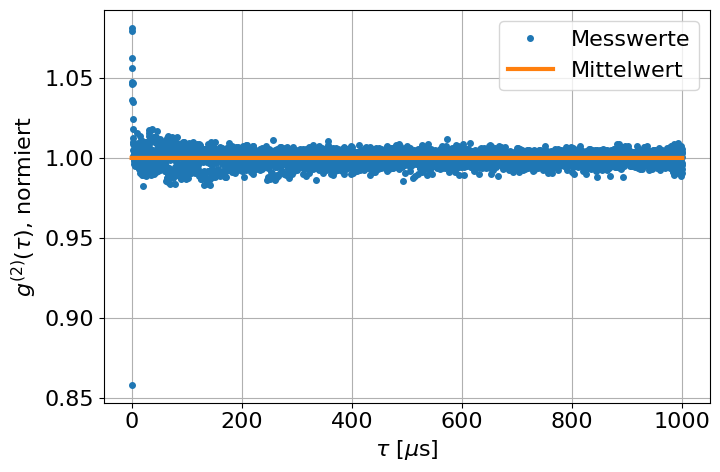

In [3]:

g2 = read_txt('3.3/3.3.2/Laserlicht_1/g2.txt', 5)
tau, rel_tau_count = g2[:,0], g2[:,1]

# Fit for g2
def h_bar(x, y_intersect):
    return y_intersect*np.ones_like(x)
popt, pcov = curve_fit(h_bar, tau, rel_tau_count)

fig,ax = plt.subplots(figsize=(7.5,5))
ax.plot(tau*1e6, rel_tau_count / popt, 'o', label='Messwerte', markersize=4)
ax.plot(tau*1e6, np.ones_like(tau), label='Mittelwert', linewidth=3)
ax.set_xlabel(r'$\tau$ [$\mu$s]')
ax.set_ylabel(r'$g^{(2)}(\tau)$, normiert')
ax.legend()
ax.grid(True)
fig.tight_layout()
fig.savefig('Plots/3.3.2_g2.pdf')
print(np.std(rel_tau_count / popt))

### Photonenstatistik

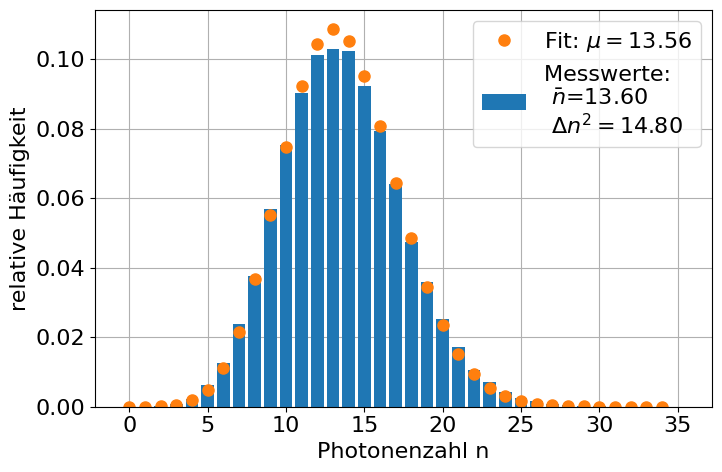

In [4]:

p_statistic = read_txt('3.3/3.3.2/Laserlicht_1/Photonen_Statistik.txt', 5)[:36] # Remove trailing zeros
photon_count, rel_photon_count = p_statistic[:,0], p_statistic[:,1]
def poisson(k, mu):
    return np.exp(-mu) * mu**k / factorial(k)
popt, pcov = curve_fit(poisson, photon_count, rel_photon_count)
n_plot = np.arange(0, 35)

var_data = np.sum(rel_photon_count * (photon_count - np.sum(photon_count*rel_photon_count))**2)
mu_data = np.sum(photon_count * rel_photon_count)
fig, ax  = plt.subplots(figsize=(7.5,5))
ax.bar(photon_count, rel_photon_count,  color=cmap[0],label='Messwerte: \n $\\bar n$={:.2f} \n $\Delta n^2={:.2f}$'.format(mu_data, var_data) )
ax.plot(n_plot, poisson(n_plot, popt), 'o',color=cmap[1] ,label='Fit: $\mu={:.2f}$'.format(popt[0]))
ax.set_xlabel('Photonenzahl n')
ax.set_ylabel('relative Häufigkeit')
ax.legend()
ax.set_axisbelow(True)
ax.grid(True)
fig.tight_layout()
fig.savefig('Plots/3.3.2_photonen_statistik.pdf')

## 3.3.3

### Überprüfung ob Lich stoß- oder dopplerverbreitert ist:

In [5]:
def g2_stoß(x, a, s):
    g1_abs =  a * np.exp(-np.abs(x)/s)
    return 1 + g1_abs**2

def g2_doppler(x, a, s):
    g1_abs =  a *  np.exp(-0.5*np.pi*x**2 * 1/s**2)
    return 1 + g1_abs**2

### BP 1

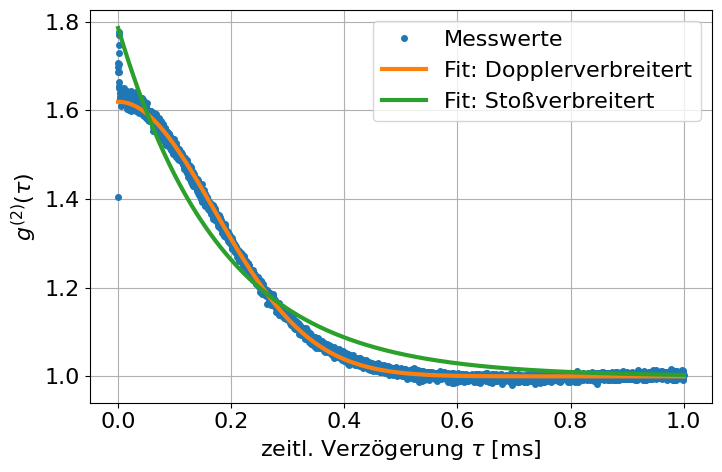

In [6]:
data = read_txt('3.3/3.3.3/Volt_3/g2.txt', 5)
tau, rel_tau_count = data[:,0], data[:,1]
# Normalize data
rel_tau_count /= np.mean(rel_tau_count[tau>0.5e-3])
x_plot = np.linspace(0, 1e-3, 1000)
# Calculate dubious yerr:
yerr = np.std(rel_tau_count[tau>0.5e-3])

# Fit for g2 + error propagation
popt_doppler, pcov_doppler = curve_fit(g2_doppler, tau, rel_tau_count, p0=[1,1e-5],sigma=yerr*np.ones_like(tau), absolute_sigma=True)
y_doppler, ycov_doppler = propagate(lambda fit_vec: g2_doppler(x_plot, *fit_vec), popt_doppler, pcov_doppler)
ycov_doppler = np.sqrt(np.diag(ycov_doppler))

popt_stoß, pcov_stoß = curve_fit(g2_stoß, tau, rel_tau_count, bounds=([0, 0], [1, 1e-3]), sigma=yerr*np.ones_like(tau), absolute_sigma=True)
y_stoß, ycov_stoß = propagate(lambda fit_vec: g2_stoß(x_plot, *fit_vec), popt_stoß, pcov_stoß)
ycov_stoß = np.sqrt(np.diag(ycov_stoß))

# Plot
fig, ax = plt.subplots(figsize=(7.5,5))
ax.plot(tau*1e3, rel_tau_count, 'o', markersize=4, color=cmap[0], label='Messwerte')
ax.plot(x_plot*1e3, y_doppler,color=cmap[1], label='Fit: Dopplerverbreitert', linewidth=3)
ax.fill_between(x_plot*1e3, y_doppler-ycov_doppler, y_doppler+ycov_doppler, alpha=0.2, color=cmap[1])
ax.plot(x_plot*1e3, y_stoß, label='Fit: Stoßverbreitert', color=cmap[2], linewidth=3)
ax.fill_between(x_plot*1e3, y_stoß-ycov_stoß, y_stoß+ycov_stoß, alpha=0.2, color=cmap[2])
ax.legend()
ax.set_xlabel(r'zeitl. Verzögerung $\tau$ [ms]')
ax.set_ylabel(r'$g^{(2)}(\tau)$')
ax.grid()
fig.tight_layout()
fig.savefig('Plots/3.3.3_BP1_g2.pdf')

### BP 2
Get list of $\tau_c$ and errors of gauss fit to g2 with different voltages:

Variiere Spannungen mit Ergebnis:
tau_c_meas: [4.25417141e-04 1.89059805e-04 1.24768403e-04 8.94896259e-05
 6.93692247e-05]
err_tau_c_meas: [1.92760644e-07 2.60856715e-07 2.16084440e-07 1.37477157e-07
 1.22313531e-07]


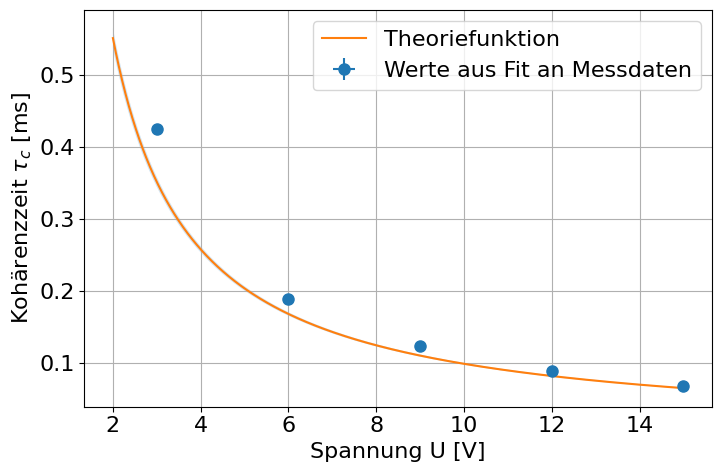

In [7]:
voltages = ['Volt_3', 'Volt_6', 'Volt_9', 'Volt_12', 'Volt_15']
tau_c_list = []
err_tau_c_list = []
for voltage in voltages:
    path = '3.3/3.3.3/' + voltage + '/g2.txt'
    data = read_txt(path, 5)
    tau, rel_tau_count = data[:,0], data[:,1]
    # Normalize data
    rel_tau_count /= np.mean(rel_tau_count[tau>0.5e-3])
    x_plot = np.linspace(0, 1e-3, 1000)
    # Calculate dubious yerr:
    yerr = np.std(rel_tau_count[tau>0.5e-3])

    # Fit for g2 + error propagation
    popt, pcov = curve_fit(g2_doppler, tau, rel_tau_count, p0=[1,1e-5], sigma=yerr*np.ones_like(tau), absolute_sigma=True)
    y, ycov = propagate(lambda fit_vec: g2_doppler(x_plot, *fit_vec), popt, pcov)
    ycov = np.sqrt(np.diag(ycov))
    tau_c = popt[1]
    err_tau_c = pcov[1,1]**0.5
    tau_c_list.append(tau_c)
    err_tau_c_list.append(err_tau_c)
    # Plot
    continue # Comment out to plot
    fig, ax = plt.subplots(figsize=(7.5,5))
    ax.plot(tau*1e3, rel_tau_count, 'o', markersize=4, color=cmap[0], label='Messwerte')
    ax.plot(x_plot*1e3, y,color=cmap[1], label=f'Fit: $\\tau_c$={tau_c:.2e}', linewidth=3)
    ax.fill_between(x_plot*1e3, y-ycov, y+ycov, alpha=0.2, color=cmap[1])
    ax.legend()
    ax.set_xlabel(r'$\tau$ [ms]')
    ax.set_ylabel(r'$g^{(2)}(\tau)$')
    ax.grid()
    ax.set_title(voltage)
    fig.tight_layout()
tau_c_list = np.array(tau_c_list)
err_tau_c_list = np.array(err_tau_c_list)
print('Variiere Spannungen mit Ergebnis:')
print('tau_c_meas:', tau_c_list)
print('err_tau_c_meas:', err_tau_c_list)

# ---------------------------------------------------------
# Then calculate the theoretical value with errorband and plot:
# ---------------------------------------------------------

# Data from different notebook in order f300, f250, f200, f150, f100 -----------------
r_arr = np.array([0.05872231, 0.04976732, 0.03979508, 0.02932104, 0.01890716]) #[mm]
err_r_arr = np.array([7.06727414e-05, 6.05129477e-05, 4.11925746e-05, 4.33617104e-05, 6.36344144e-05]) #[mm]
# --------------------------
r, err_r = r_arr[2], err_r_arr[2] # Values for f200
dist = 37 #[mm]
U = np.array([3, 6, 9, 12, 15]) #[V]

def calc_nu(U):
    return 0.31209*U-0.0736, np.sqrt((0.0009*U)**2 + 0.006**2 + ((0.01*U+0.02)*0.312)**2)
nu, err_nu = calc_nu(U)
def calc_tau_c(U, r, dist):
    nu = calc_nu(U)[0]
    return r / (2*np.sqrt(np.pi)*dist*nu)

U_plot = np.linspace(2, 15, 1000)
tau_c_theory = calc_tau_c(U, r, dist)
tau_c_plot = calc_tau_c(U_plot, r, dist)
err_tau_c_theory = np.sqrt((1 / (2*np.sqrt(np.pi)*dist*calc_nu(U_plot)[0]) * err_r)**2 + (r / (2*np.sqrt(np.pi)*dist*calc_nu(U_plot)[0]**2) * calc_nu(U_plot)[1])**2)

fig, ax = plt.subplots(figsize=(7.5,5))
ax.errorbar(U, tau_c_list*1e3, err_tau_c_list*1e3, 0, 'o', label='Werte aus Fit an Messdaten')
ax.plot(U_plot, tau_c_plot*1e3,label='Theoriefunktion')
ax.fill_between(U_plot, (tau_c_plot-err_tau_c_theory)*1e3, (tau_c_plot+err_tau_c_theory)*1e3, alpha=0.2)
ax.set_xlabel('Spannung U [V]')
ax.set_ylabel('Kohärenzzeit $\\tau_c$ [ms]')
ax.legend()
ax.grid()
fig.tight_layout()
fig.savefig('Plots/3.3.3_BP2_tau_c.pdf')

### BP 3: Intensitätenspektrum für 9V

Breite Sigma: 14.205951238644541 10^3/s
0.00012476840312417083 2.1608443961553884e-07
2978754096324077.0


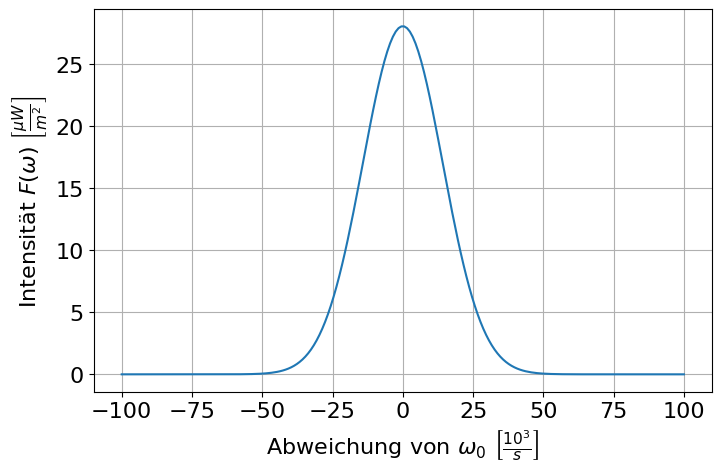

In [8]:
tau_c = tau_c_list[2]
err_tau_c = err_tau_c_list[2]
omega_0 = 3e8 / 632.8e-9 *2*np.pi

d_omega_plot = np.linspace(- 1e5,  1e5, 200) 
def spectral_intensity(d_w, tau_c):
    return tau_c/(np.sqrt(2)*np.pi) * np.exp(-(d_w)**2 *( tau_c)**2 / (2*np.pi))

I_max = spectral_intensity(0, tau_c)
fig, ax = plt.subplots(figsize=(7.5,5))
ax.plot(d_omega_plot*1e-3 , spectral_intensity(d_omega_plot, tau_c)*1e6)
ax.ticklabel_format(useOffset=False)

ax.set_ylabel('Intensität $F(\omega)$ $\left[\\frac{\mu W}{m^2}\\right]$')
ax.set_xlabel('Abweichung von $\\omega_0$ $\left[\\frac{10^3}{s}\\right]$')

ax.grid()
fig.tight_layout()
fig.savefig('Plots/3.3.3_BP3_spektralintensität.pdf')
print('Breite Sigma:', np.sqrt(np.pi)/tau_c *1e-3, '10^3/s')
print(tau_c, err_tau_c)
print(omega_0)

### BP 4: variiere Brennweiten

tau_c_meas: [1.56402781e-04 1.18466290e-04 1.09916717e-04 7.44718921e-05
 5.16772482e-05]
err_tau_c_meas: [1.29805706e-07 2.57739471e-07 1.60403763e-07 1.25920036e-07
 8.81530972e-08]


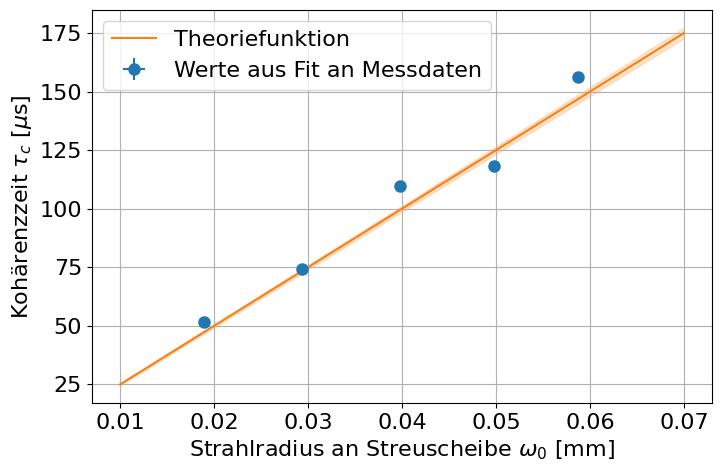

In [9]:
f_list = ['focal_300', 'focal_250', 'focal_200', 'focal_150', 'focal_100']
tau_c_list = []
err_tau_c_list = []
for f in f_list:
    path = '3.3/3.3.3/' + f + '/g2.txt'
    data = read_txt(path, 5)
    tau, rel_tau_count = data[:,0], data[:,1]
    # Normalize data
    rel_tau_count /= np.mean(rel_tau_count[tau>0.5e-3])
    x_plot = np.linspace(0, 1e-3, 1000)
    # Calculate dubious yerr:
    yerr = np.std(rel_tau_count[tau>0.5e-3])

    # Fit for g2 + error propagation
    popt, pcov = curve_fit(g2_doppler, tau, rel_tau_count, p0=[1,1e-5], sigma=yerr*np.ones_like(tau), absolute_sigma=True)
    y, ycov = propagate(lambda fit_vec: g2_doppler(x_plot, *fit_vec), popt, pcov)
    ycov = np.sqrt(np.diag(ycov))
    tau_c = popt[1]
    err_tau_c = pcov[1,1]**0.5
    tau_c_list.append(tau_c)
    err_tau_c_list.append(err_tau_c)
    # Plot
    continue # Comment out to plot
    fig, ax = plt.subplots(figsize=(7.5,5))
    ax.plot(tau*1e3, rel_tau_count, 'o', markersize=4, color=cmap[0], label='Messwerte')
    ax.plot(x_plot*1e3, y,color=cmap[1], label=f'Fit: $\\tau_c$={tau_c:.2e}', linewidth=3)
    ax.fill_between(x_plot*1e3, y-ycov, y+ycov, alpha=0.2, color=cmap[1])
    ax.legend()
    ax.set_xlabel(r'$\tau$ [ms]')
    ax.set_ylabel(r'$g^{(2)}(\tau)$')
    ax.grid()
    ax.set_title(f)
    fig.tight_layout()
tau_c_list = np.array(tau_c_list)
err_tau_c_list = np.array(err_tau_c_list)
print('tau_c_meas:', tau_c_list)
print('err_tau_c_meas:', err_tau_c_list)

# ---------------------------------------------------------
# Then calculate the theoretical value with errorband and plot:
# ---------------------------------------------------------

# Data from different notebook in order f300, f250, f200, f150, f100 -----------------
r_arr = np.array([0.05872231, 0.04976732, 0.03979508, 0.02932104, 0.01890716]) #[mm]
err_r_arr = np.array([7.06727414e-05, 6.05129477e-05, 4.11925746e-05, 4.33617104e-05, 6.36344144e-05]) #[mm]
# --------------------------

dist = 37 #[mm]
U = 10 #[V]


def calc_nu(U):
    return 0.31209*U-0.0736, np.sqrt((0.0009*U)**2 + 0.006**2 + ((0.01*U+0.02)*0.312)**2)
nu, err_nu = calc_nu(U)
def calc_tau_c(U, r, dist):
    nu = calc_nu(U)[0]
    return r / (2*np.sqrt(np.pi)*dist*nu)

r_plot = np.linspace(0.01, 0.07, 1000)
tau_c_theory = calc_tau_c(U, r_arr, dist)
tau_c_plot = calc_tau_c(U, r_plot, dist)
err_tau_c_theory = np.sqrt((1 / (2*np.sqrt(np.pi)*dist*nu) * np.mean(err_r_arr))**2 + (r_plot / (2*np.sqrt(np.pi)*dist*nu**2) * err_nu)**2)

fig, ax = plt.subplots(figsize=(7.5,5))
ax.errorbar(r_arr, tau_c_list*1e6, err_tau_c_list*1e6, 0, 'o', label='Werte aus Fit an Messdaten', color= cmap[0])
ax.plot(r_plot, tau_c_plot*1e6, label='Theoriefunktion', color=cmap[1])
ax.fill_between(r_plot, (tau_c_plot-err_tau_c_theory)*1e6, (tau_c_plot+err_tau_c_theory)*1e6, alpha=0.2, color=cmap[1])
ax.set_xlabel('Strahlradius an Streuscheibe $\omega_0$ [mm]')
ax.set_ylabel('Kohärenzzeit $\\tau_c$ [$\mu$s]')
ax.legend()
ax.grid()
fig.tight_layout()
fig.savefig('Plots/3.3.3_BP4_tau_c.pdf')

### BP 5: Photonenstatistik: Nutze Messung bei 10V=const und f250. Abweichung von Theorie hier recht klein

Mittelwert aus Fit: 6.384735686077055
Mittelwert aus Daten: 7.869830913435033


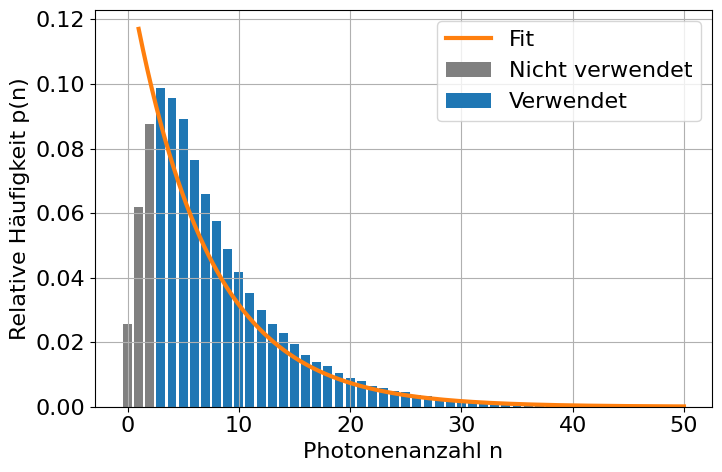

In [13]:
data = read_txt('3.3/3.3.3/focal_150/Photonen_Statistik.txt', 5)
count, rel_count = data[:,0], data[:,1]
# Split the data into two parts, fit is only performed on x_2, y_2:
x_1, x_2 = np.split(count, [3])
y_1, y_2 = np.split(rel_count, [3])
#x_2, y_2 = count, rel_count
def bose(x, m):
    return m**x / ((1+m)**(1+x))
popt, pcov = curve_fit(bose, x_2, y_2)
x_plot = np.linspace(1,50,1000)
fig, ax = plt.subplots(figsize=(7.5,5))
ax.bar(x_1, y_1, color='grey', label='Nicht verwendet')
ax.bar(x_2, y_2, color=cmap[0], label='Verwendet')
ax.plot(x_plot, bose(x_plot, *popt), color=cmap[1], label='Fit', linewidth=3)
ax.set_xlabel('Photonenanzahl n')
ax.set_ylabel('Relative Häufigkeit p(n)')
ax.legend()
ax.grid()
fig.tight_layout()
fig.savefig('Plots/3.3.3_BP5_photonen_statistik.pdf')
print('Mittelwert aus Fit:', popt[0])
print('Mittelwert aus Daten:', np.sum(count*rel_count))

### BP 6

In [20]:
dirs = ['Volt_3', 'Volt_6', 'Volt_9', 'Volt_12', 'Volt_15', 'focal_300', 'focal_250', 'focal_200', 'focal_150', 'focal_100']
del_n2_from_g2 = []
del_n2_from_pstat = []
p_bar = []
p_bar_err =[]
for dir in dirs:
    path = '3.3/3.3.3/' + dir + '/Photonen_Statistik.txt'
    data = read_txt(path, 5)
    p, rel_p_count = data[:,0], data[:,1]
    
    path = '3.3/3.3.3/' + dir + '/g2.txt'
    data = read_txt(path, 5)
    tau, rel_tau_count = data[:,0], data[:,1]
    #Normalize data
    rel_tau_count /= np.mean(rel_tau_count[tau>0.5e-3])
    # Calculate dubious yerr:
    yerr = np.std(rel_tau_count[tau>0.5e-3])
    
    p_mean = np.sum(p*rel_p_count)
    p_err = np.sum(rel_p_count * (p - np.sum(p*rel_p_count))**2)**0.5
    popt_doppler, pcov_doppler = curve_fit(g2_doppler, tau, rel_tau_count, p0=[1,1e-5],sigma=yerr*np.ones_like(tau), absolute_sigma=True)
    g2, g2_err = propagate(lambda fit_vec: g2_doppler(0, *fit_vec), popt_doppler, pcov_doppler)
    g2_err = np.sqrt(np.diag(ycov_doppler))[0,0]
    
    del_n2 = (g2-1)*p_mean**2 + p_mean
    del_n2_err = np.sqrt((g2_err*p_mean)**2 + ((2*(g2-1) +1)*p_err)**2)
    del_n2_from_g2.append((del_n2, del_n2_err))
    del_n2_from_pstat.append(p_err**2)
    p_bar.append(p_mean)
    p_bar_err.append(p_err)
del_n2_from_g2 = np.array(del_n2_from_g2)
del_n2_from_pstat = np.array(del_n2_from_pstat)
p_bar = np.array(p_bar)
p_bar_err = np.array(p_bar_err)
print('g2', np.mean(del_n2_from_g2, axis=0))  
print('Photonenstatistik', np.mean(del_n2_from_pstat))

g2 [45.46166451 15.2882824 ]
Photonenstatistik 44.28753010470042


In [30]:
print(np.std(del_n2_from_g2, axis=0))

[11.11304117  2.52895795]


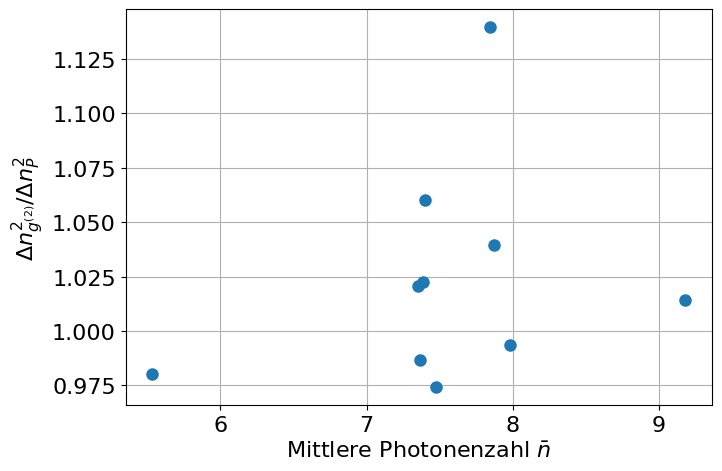

In [29]:
fig, ax = plt.subplots(figsize=(7.5,5))
ax.plot(p_bar, del_n2_from_g2[:,0] / del_n2_from_pstat, 'o')
ax.set_xlabel('Mittlere Photonenzahl $\\bar n$')
ax.set_ylabel('$\\Delta n^2_{g^{(2)}} / \\Delta n^2_P$ ')
ax.grid()
fig.tight_layout()
fig.savefig('Plots/3.3.3_BP6_Photonenzahlfluktuation.pdf')